# An overview of Chicago crime

This notebook looks at when and where crimes occur in Chicago. First we read in the data and discuss a little bit of the data cleaning that was already done. To jump straight to the results, as well as a description of the data, go to [the overview](#overview). Go [here](#time) to see both short-term and long-term trends in crime. Go [here](#location) (or [to this interactive visualization](http://www.physics.rutgers.edu/~applebaum/visualizations/)) to see where crimes occur. Finally, you can go [here](#psd) to see some spectral analysis.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import read_data as rd
import scipy.stats as ss
import scipy.fftpack as fft
import scipy.signal as ssi
import seaborn as sns
from sklearn.linear_model import LinearRegression
import geopandas
import cartopy
pd.options.display.max_columns = 999
pd.options.display.max_rows = 77
from shapely.geometry import Point
import shapely.ops as shops
import plotly.express as px
import datetime

%matplotlib inline

## Read in data 

The function `read_crime_data` reads in the data and does a bit of cleaning. It converts dates and times to pandas datetime format and indexes by them. It eliminates a handful of data that appear to be well outside the city limits. It renames a handful of entry types for consistency. Importantly, there are many missing values for "Community Area," which indicates the neighborhood in which a crime took place. By finding the neighborhood in which a particular longitude/latitude point is, I fill in these missing values.

This latter process if pretty slow, unfortunately, so I went through them all once, and saved the cleaned up DataFrame as an hdf file. I leave the (commented) code here if anyone wishes to reproduce my new table.

In [2]:
# filename = '/home/elaad/Documents/DatAnalysis/datasets/Crimes_-_2001_to_present.csv'
geofilename = '/home/elaad/Documents/DatAnalysis/datasets/Boundaries_Community_Areas/'
# crimedata = rd.read_crime_data(filename, usecols=[0, 2, 5, 6, 7, 8, 9, 13, 17, 19, 20], dtype=None,
#                                clean=True, geofilename=geofilename)

In [3]:
# crimedata.to_hdf('/home/elaad/Documents/DatAnalysis/datasets/chicago_crimes.hdf', key='crimes')

In [4]:
# This is the primary DataFrame I'll be using, containing the crime data
crimedata = pd.read_hdf('/home/elaad/Documents/DatAnalysis/datasets/chicago_crimes.hdf')

# More cleaning of data needed
# Fix inconsistent labeling
crimedata.loc[crimedata['Primary Type'].str.startswith('NON'), 'Primary Type'] = 'NON-CRIMINAL'
# Domestic crimes are a separate boolean array, 
# so there is only one crime labeled as "DOMESTIC VIOLENCE", which we remove
crimedata = crimedata.loc[crimedata['Primary Type'] != 'DOMESTIC VIOLENCE']

Census data:

In [5]:
census_dat = pd.read_excel('/home/elaad/Documents/DatAnalysis/datasets/CCASF12010CMAP.xlsx',
                          index_col=1, header=1, skiprows=0)

Geographic data:

In [6]:
geodf = geopandas.read_file(geofilename)
geodf['area_num_1'] = pd.to_numeric(geodf['area_num_1'])
geodf = geodf.set_index('area_num_1').sort_index()

## Overview
<a id='overview'></a>

The dataset represents a collection of ${\sim}7$ million crimes reported in Chicago between 2001 and 2019 (I have excluded 2020).

<sup>Caveat: With the exception of homicides, all data are from reported crimes. The disclaimer from the data website is "These crimes may be based upon preliminary information supplied to the Police Department by the reporting parties that have not been verified. The preliminary crime classifications may be changed at a later date based upon additional investigation and there is always the possibility of mechanical or human error." Therefore, the dataset may contain errors. However, I will assume for the sake of this analysis that most crimes are accurately reported and that no results depend sensitively on small changes to the dataset.</sup>

The dataset in this notebook does not include all of the fields that are available in the [original dataset](https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-Present/ijzp-q8t2), which also include information like police beat/district and city council ward. The data here include the date, the type of offense, a description of the offense, location, whether an arrest was made, whether it was a domestic offense (as defined by the Illinois Domestic Violence Act), the Community Area (neighborhood) in which the crime occured, and its Latitute/Longitude.

Here we see five random crimes, for example:

In [7]:
crimedata.sample(5)

,ID,Primary Type,Description,Location Description,Arrest,Domestic,Community Area,Year,Latitude,Longitude
Date,,,,,,,,,,
2014-08-02 01:00:00,9720949,THEFT,POCKET-PICKING,TAVERN/LIQUOR STORE,False,False,7.0,2014,41.922515,-87.644662
2001-02-19 13:02:21,1399821,NARCOTICS,POSS: HEROIN(WHITE),STREET,True,False,23.0,2001,41.897160,-87.719887
2018-05-21 22:51:00,11322334,WEAPONS VIOLATION,RECKLESS FIREARM DISCHARGE,STREET,False,False,19.0,2018,41.936543,-87.781616
2007-07-14 00:30:00,5655619,ASSAULT,SIMPLE,RESIDENCE,True,True,64.0,2007,41.775140,-87.752965
2009-06-26 18:45:00,6991826,BATTERY,AGGRAVATED: OTHER DANG WEAPON,PARK PROPERTY,False,False,24.0,2009,41.908671,-87.697533


In the next few plots we focus on how many total crimes there were, and focus in on theft as an example.

For future use we define a function that plots a bar chart for us with our preferred formatting.

In [8]:
def horizontal_bar(counts, title=None, **kwargs):
    """Plot a horizontal bar chart with some nice formatting
    
    Args:
        counts : pandas series with crime counts
        title : preferred title
        **kwargs : passed to the plotting function
    """
    fig, ax = plt.subplots(1, 1)

    counts.plot(kind='barh',
                ax=ax, **kwargs)

    # turn off unneeded axis lines
    for loc in ['right', 'bottom', 'top']:
        ax.spines[loc].set_visible(False)

    # add numerical labels
    for p in ax.patches:
        ax.text(p.get_width() * 1.2, p.get_y() + 0.5 * p.get_height(), 
                f'{p.get_width():,}', va='center', fontsize=12)

    # more formatting
    if title is not None:
        ax.set_title(f'{title}\n', fontsize=18)
    ax.set_xscale('log')
    ax.tick_params('x', which='both', bottom=False, labelbottom=False)
    ax.tick_params('y', labelsize=14)

So: what are the most common crimes? We can see the distribution in this bar chart (NB: the bars are on a log scale, so a small change in height can mean a big change in number).

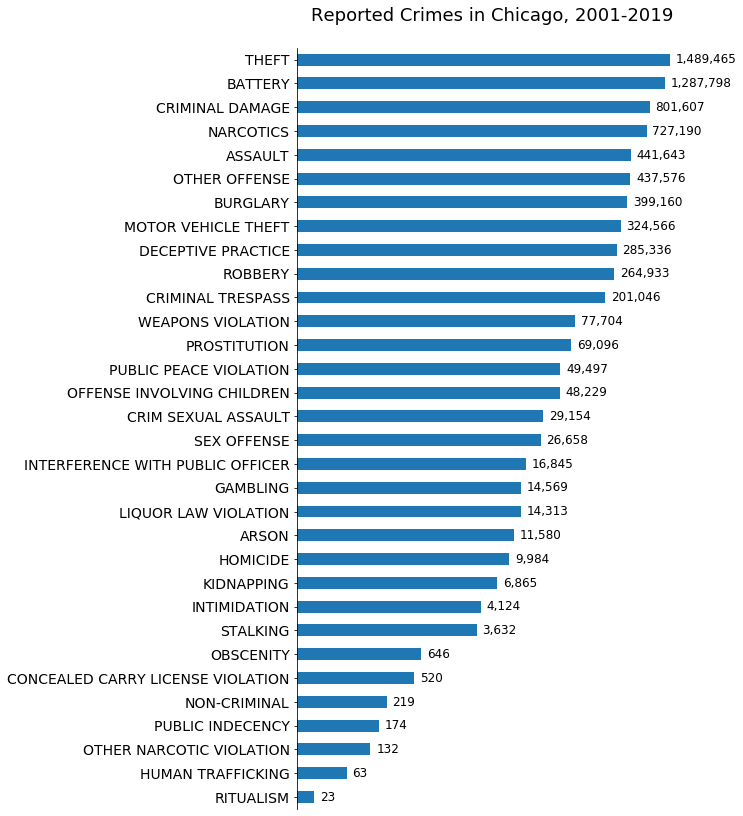

In [9]:
# find the counts
counts = crimedata['Primary Type'].value_counts(ascending=True)

# plot using above-defined function
horizontal_bar(counts, title='Reported Crimes in Chicago, 2001-2019',
               figsize=(7, 14))

So, thefts are the most common crime, followed by battery. This is not terribly surprising. Of, say, thefts, what are the most common descriptors?

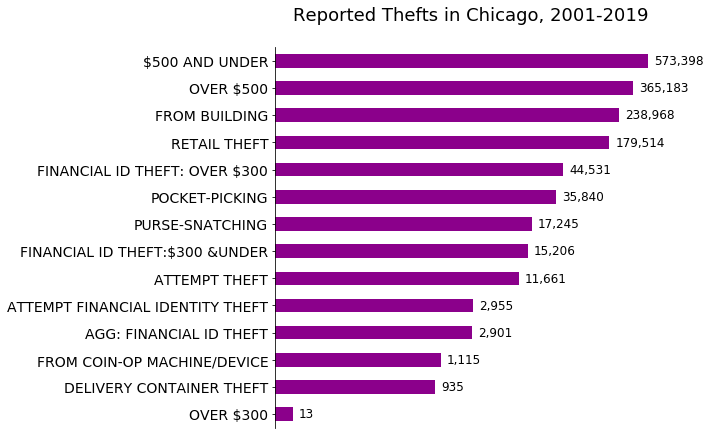

In [10]:
# first, fixing a mislabelled case
crimedata.loc[crimedata['Description'] == 'THEFT RETAIL', 'Description'] = 'RETAIL THEFT'

# find the counts
counts = crimedata.loc[crimedata['Primary Type'] == 'THEFT', 'Description'].value_counts(ascending=True)

# plot using above-defined function
horizontal_bar(counts, title='Reported Thefts in Chicago, 2001-2019',
               figsize=(7, 7), color='darkmagenta')


The most common theft description is \\$500 and under, followed by over \\$500; small amounts are more common than large. For Financial ID Theft, however, it is the other way around, with higher amounts more common.

The least common category, "OVER \\$300", might be a data input error, intended to be OVER \\$500.

Finally, let's ask: of petty theft (those worth \\$500 and under), where do they tend to happen? In this case, there are too many different locations for us to want to plot, so let's focus on just the 10 most common:

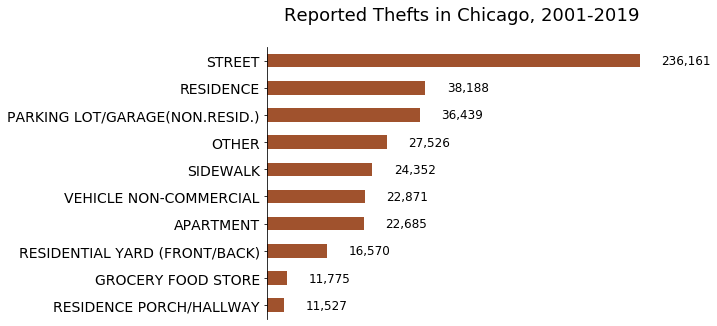

In [11]:
petty_theft = crimedata.query('`Primary Type` == "THEFT" and Description == "$500 AND UNDER"')
counts = petty_theft['Location Description'].value_counts()[:10][::-1]  # swap order for bar chart
horizontal_bar(counts, title='Reported Thefts in Chicago, 2001-2019',
               figsize=(7, 5), color='sienna')

In summary, between 2001 and 2019 in the city of Chicago, there were 236,161 reported thefts of $500 and under that occurred on the street.

## Crimes as a function of time and date
<a id='time'></a>

The next few plots show the rate of crimes as a function of time, day of the week, day of the month, month, and year. I discuss them below.

Some assumptions certainly go into the believability of these plots.
For example:
* Listed information---particularly dates and times---are precise and accurate. As we show in looking at the reported times of thefts, this is a poor assumption.
* Crimes are not reported with equal frequency, and may occur at different rates than end up being reported.

We'll focus on four crimes of interest: homicide, theft, battery, and narcotics. We'll also show the results of all crimes put together for comparison.

In [12]:
crimes_of_interest = ['Homicide', 'Battery', 'Theft', 'Narcotics']

### Helpful plotting functions

These functions are used later.

In [13]:
from matplotlib.ticker import PercentFormatter
def to_percent(vals):
    """Shift time series to percent relative to mean"""
    return 100 * (vals / vals.mean() - 1)

def calculate_rotation(xs, ys, ind, ax):
    """Return position and rotation of text label to align with plotted line"""
    xs, ys = np.array(xs), np.array(ys)
    if int(ind) == ind:
        rotation = np.arctan2((ys[ind + 1] - ys[ind - 1]), 
                               xs[ind + 1] - xs[ind - 1])
        xt, yt = xs[ind], ys[ind]
    else:
        rotation = np.arctan2(ys[int(ind) + 1] - ys[int(ind)],
                              xs[int(ind) + 1] - xs[int(ind)])
        xt = np.mean(xs[[int(ind) + 1, int(ind)]])
        yt = np.mean(ys[[int(ind) + 1, int(ind)]])
    rotation *= 180. / np.pi
    rotation = ax.transData.transform_angles(np.array([rotation]), 
                                             np.array([[xt, yt]]))[0]
    return xt, yt, rotation

def generate_yaxis(ax, ticks, center='Daily\nAverage'):
    """Format the ytick labels using % signs"""
    def choose_plus_minus(val):
        return '+' if val > 0 else '-'
    ax.set_yticks(ticks)
    ax.set_yticklabels([f'{choose_plus_minus(y)}{y}%' if y !=0 else f'{center}' for y in ax.get_yticks()])
    
def plot_rate_and_label(ax, times, vals, label, label_ind, label_shift, 
                        plot_kw={}, text_kw={}):
    """Plot the crime rate and add the text label
    
    Args:
        ax : the axis object
        times : x axis data
        vals : y axis data
        label : the text label
        label_ind : the index at which to place the text label
            either at the index or between two indices (i.e., 5 or 5.5)
        label_shift : how much to shift the label above or below the line,
            in data units
    """
    times, vals = np.array(times), np.array(vals)
    perc = to_percent(vals)
    l, = ax.plot(times, perc, **plot_kw)
    xt, yt, rotation = calculate_rotation(l.get_xdata(), l.get_ydata(), label_ind, ax)
    ax.text(xt, yt + label_shift, 
            label, color=l.get_color(), fontsize=text_kw.pop('fontsize', 15), 
            rotation=rotation, ha=text_kw.pop('ha', 'center'), va='center', 
            transform=ax.transData, **text_kw)

### Crimes by time of day

Here we see the crime rate as a function of the time of day, for a few different crime types, as well as for all crime.

There are a few interesting things to note here. Crimes generally seem to be least frequent around 5 AM, while homicides bottom out around 7-8 AM. Homicides also seem to peak a bit later than most crimes. Thefts, on the other hand, peak in the afternoon (except for a spike around noon, which I will assume for now comes from thefts around the lunch hour, and a spike at midnight, which could be real or could be a data/reporting issue). All of these observations are consistent with a general idea that most crimes require people to be around, while homicides occur when people *aren't* around.

Narcotics crimes vary the most of any shown here, with substantial spikes around midday and evening, such that the 7:00 PM rate is about twice the 12:00 PM rate, and over 30 times higher than the 5:00 AM rate. As much as the true underlying incidence of drug usage, this variation is probably a reflection of when police choose to make arrests or complete their paperwork (in other words, narcotics crimes likely aren't reported to police by third parties, but rather reported by the police themselves; this point is returned to in [the arrests notebook](02-arrests.ipynb)).

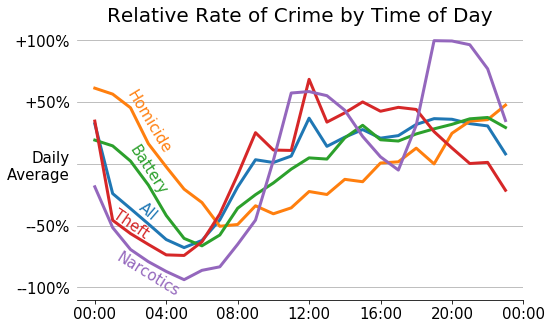

In [14]:
with plt.style.context('mplstyles/crimerate.mplstyle'):
    fig, ax = plt.subplots(1, 1)
    
    # aggregate counts, grouped by time of day and crime type
    agg = crimedata.groupby(by=['Primary Type', crimedata.index.hour]).size()
    # also get counts for all crimes
    agg_all = agg.sum(level=1)
    
    # for the text labels below
    dist_from_line = [18, 12, 8, -10]  # distance above or below line
    loc_on_line = [3, 3, 2, 3]  # location on line
    
    # set limits and labels
    ax.set_xlim([-1, 24])
    ax.set_ylim([-110, 110])
    generate_yaxis(ax, [-100, -50, 0, 50, 100])
    ax.set_xticks(np.arange(0, 28, 4))
    ax.set_xticklabels([f'{int(t%24):02}:00' for t in ax.get_xticks()])
    ax.set_title('Relative Rate of Crime by Time of Day')
    
    # function, defined above, plots the line + adds the text label
    # first, plot all crimes
    plot_rate_and_label(ax, agg_all.index, agg_all, 'All', 3, 10)
    
    # plot individual crimes
    for dist, loc, crime in zip(dist_from_line, loc_on_line, crimes_of_interest):
        plot_rate_and_label(ax, 
                            agg.loc[crime.upper()].index, agg.loc[crime.upper()], 
                            crime, loc, dist)

**NB:** The times at which crimes occur, as all data, are subject to bias and error. The above figure looked only at the hour in which a crime was reported, which yields a fairly smooth curve. Let's say we sampled times every 15 minutes, instead. Below, we see what reported narcotics crimes and thefts look like. Nartotics crimes are smooth, indicating perhaps a higher level of accuracy and precision in the times. Thefts, on the other hand, tend to spike on the hour, with smaller peaks on the half hour. This periodicity may indicate that people reporting thefts to police tend to round the time during the report.

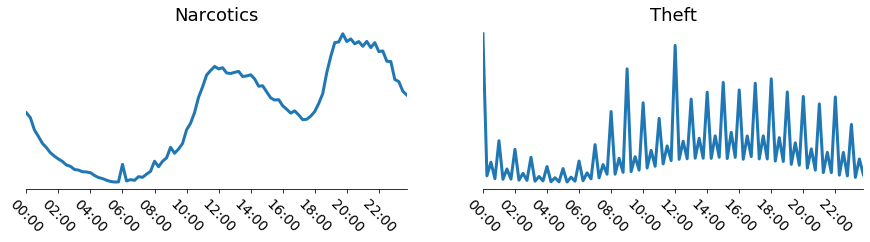

In [15]:
fig, ax = plt.subplots(1, 2, sharex=True, figsize=(15, 3))

for i, crime in enumerate(['NARCOTICS', 'THEFT']):
    # plot the time series, by time of day, rounded to 15 minute intervals
    crimeslice = crimedata.loc[crimedata['Primary Type'] == crime]
    crimeslice.groupby(crimeslice.index.round('15min').time).size().plot(ax=ax[i], lw=3)
    
    # set labels
    ax[i].set_title(crime.title(), fontsize=18)
    ax[i].set_xlabel('')
    ax[i].tick_params(axis='x', labelsize=14, labelrotation=-45)
    
    # remove unneeded axis lines
    for loc in ['left', 'top', 'right']:
        ax[i].spines[loc].set_visible(False)
    ax[i].set_yticks([])

# adjust axis labels
ax[0].set_xticks([datetime.time(x) for x in np.arange(0, 24, 2)])
plt.show()  # prevent returned object from printing

### Crimes by day of week

Here we investigate how crime varies depending on the day of the week; specifically, we compare weekdays (Monday through Friday) and weekends (Saturday and Sunday). The figure below shows how the weekend crime rate compares to the weekday crime rate.

When considering all crimes (of which there are over 7 million spread over 19 years, so ~1000 per day), there is little dependence on weekday/weekend. There is only a few percent decrease in crime on weekends.

We see that there is variation, however, when looking at individual crimes. Homicides, for example, occur at a much higher rate on weekends than on weekdays, as does battery. Theft occurs somewhat less frequently on weekends, which may be driven by the reduction in workday crowds and the concentration of theft in the business district (see below). Finally, there is a ~14% decrease in drug crimes on weekends. As in the daily crime rate, this decrease is likely a product of reduced drug enforcement, rather than reduced drug usage.

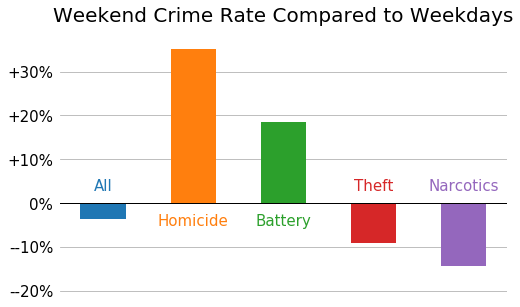

In [16]:
with plt.style.context('mplstyles/crimerate.mplstyle'):
    fig, ax = plt.subplots(1, 1)
    
    # Want average daily counts, separated into weekday/weekend:
    # first, aggregate counts, grouped by day of week
    agg = crimedata.groupby(by=['Primary Type', crimedata.index.weekday]).size()
    # second, find the mean daily counts on weekdays and weekends
    weekdays = agg.loc[agg.index.get_level_values(1) < 5].mean(level=0)
    weekends = agg.loc[agg.index.get_level_values(1) >= 5].mean(level=0)
    # the weekend increase (or decrease) relative to weekday
    increase = (weekends - weekdays) / weekdays * 100
    
    # setting labels and limits
    ax.set_ylim([-22, 40])
    generate_yaxis(ax, [-20, -10, 0, 10, 20, 30], center='0%')
    ax.spines['bottom'].set_visible(False)
    ax.set_xticks([])
    ax.axhline(0, color='black', lw=1)
    ax.set_title('Weekend Crime Rate Compared to Weekdays')
    
    # plotting all crimes
    tot_increase = (weekends.sum() - weekdays.sum()) / weekdays.sum() * 100
    b = ax.bar(0, tot_increase, width=0.5)
    
    # label is placed either above or below the bar, depending on if
    # the bar is negative or positive
    ax.text(0, (tot_increase < 0) * 8 - 4, 'All',
                color=b.patches[0].get_facecolor(), ha='center', va='center', fontsize=15)
    
    # plotting individual crimes
    for i, crime in enumerate(crimes_of_interest):
        b = ax.bar(1 + i, increase.loc[crime.upper()], width=0.5)
        ax.text(1 + i, (increase.loc[crime.upper()] < 0) * 8 - 4, crime.title(),
                color=b.patches[0].get_facecolor(), ha='center', va='center', fontsize=15)

### Crimes by time of year

Here we see crime by month of year${}^1$.

Generally, there is more crime in the summer than in the winter (given Chicago's famously rough winters, people are likely less inclined to go outside, which reduces the opportunity for crime). The crime type with the greatest variation between winter and summer is Homicide: there are nearly twice as many homicides per day in July as in February. The only crime which doesn't vary seasonally is narcotics, which instead is fairly flat.

<sup>1. To avoid the pitfall of the results reflecting the different lengths of different months (i.e., from 28-31 days), we calculate the mean daily crime rate per month, not the total crime per month.</sup>

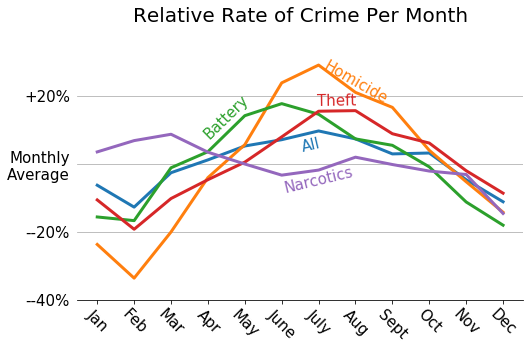

In [17]:
with plt.style.context('mplstyles/crimerate.mplstyle'):
    fig, ax = plt.subplots(1, 1)
    
    # aggregate counts, grouped by month, day, and crime type
    # we first calculate daily counts because we don't want the variable month
    # lengths to affect the results
    # then we find the mean daily rate within each month
    agg = crimedata.groupby(by=['Primary Type', crimedata.index.month, crimedata.index.day]).size()
    
    # all crimes: group by month, find mean daily rate
    agg_all = agg.groupby(agg.index.get_level_values(1)).mean()
    # separated by crime: group by crime + month, find mean daily rate
    agg = agg.groupby(['Primary Type', agg.index.get_level_values(1)]).mean()
    
    # limits and labels
    ax.set_title('Relative Rate of Crime Per Month')
    generate_yaxis(ax, [-40, -20, 0, 20], center='Monthly\nAverage')
    ax.set_xticks(np.arange(1, 13))
    ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 
                        'May', 'June', 'July', 'Aug', 'Sept', 
                        'Oct', 'Nov', 'Dec'], rotation=-45)
    ax.set_ylim([-40, 40])
    
    # plot all crimes, again using predefined plotting function
    plot_rate_and_label(ax, agg_all.index, agg_all, 'All', 5.5, -3, 
                        text_kw={'ha':'left'})
    
    # these determine where to place the text labels
    dist_from_line = [3, 5, 3, -3]  # distance above or below line
    loc_on_line = [7, 3.5, 6.5, 6]  # location on the line to place text
    
    # plotting by individual crime
    for dist, loc, crime in zip(dist_from_line, loc_on_line, crimes_of_interest):
        plot_rate_and_label(ax, 
                            agg.loc[crime.upper()].index, agg.loc[crime.upper()], 
                            crime, loc, dist)

### Long-term trends

Crime generally has fallen over the last several decades across the United States[${}^*$](https://www.theatlantic.com/politics/archive/2016/04/what-caused-the-crime-decline/477408/). Here we look at Chicago's long-term trends. Let's focus on the 5 most common crimes, and combine the rest together: Theft, Battery, Criminal Damage, Narcotics, and Assault. From 2001-2019, they together constitute 2/3 of all reported crimes. The table shows what fraction of all reported crimes each of these constitute.

In [18]:
# making into a DataFrame and renaming column at end for nice formatting
pd.DataFrame((crimedata['Primary Type'].value_counts()
              / len(crimedata))[:5]).rename(columns={'Primary Type': 'Crime Fraction'})

,Crime Fraction
THEFT,0.211441
BATTERY,0.182813
CRIMINAL DAMAGE,0.113794
NARCOTICS,0.103230
ASSAULT,0.062695


In [19]:
# let's focus on the top 5, as stated above
top_crimes = crimedata['Primary Type'].value_counts()[:5].index

# making a version where all crimes that aren't in the top 5 are grouped
crimedata2 = crimedata[['Primary Type']].copy()
# replace crimes not in top_crimes with "ALL OTHERS" designation
crimedata2 = crimedata2.replace([cr for cr in crimedata2['Primary Type'].unique() 
                                 if cr not in top_crimes], 
                                'ALL OTHERS')

Below we see the long-term trends in crime. We smooth over a full year to get rid of seasonal effects, which would render the plot difficult to read.

Crime generally has gone down over the last 19 years, almost by a factor of 2. The decline may have leveled since 2016, however. Additionally, it seems that not all crimes have declined evenly. Narcotics, for example, experienced a long, slow decline, and then a more precipitous decline around 2016, when the state of Illinois decriminalized marijuana. Assaults declined in line with other crimes, and increased again starting around 2015. Barring these details, however, it is clear that crime was substantially higher 20 years ago than it is today.

In [20]:
# count crimes by date and type
agg = crimedata2.groupby(['Primary Type', crimedata2.index.date]).size()
# apply 365 day rolling mean for each crime
agg_mean = (agg.groupby('Primary Type')
               .apply(lambda x: x.rolling(365).mean())
               .dropna().reset_index(level=0))

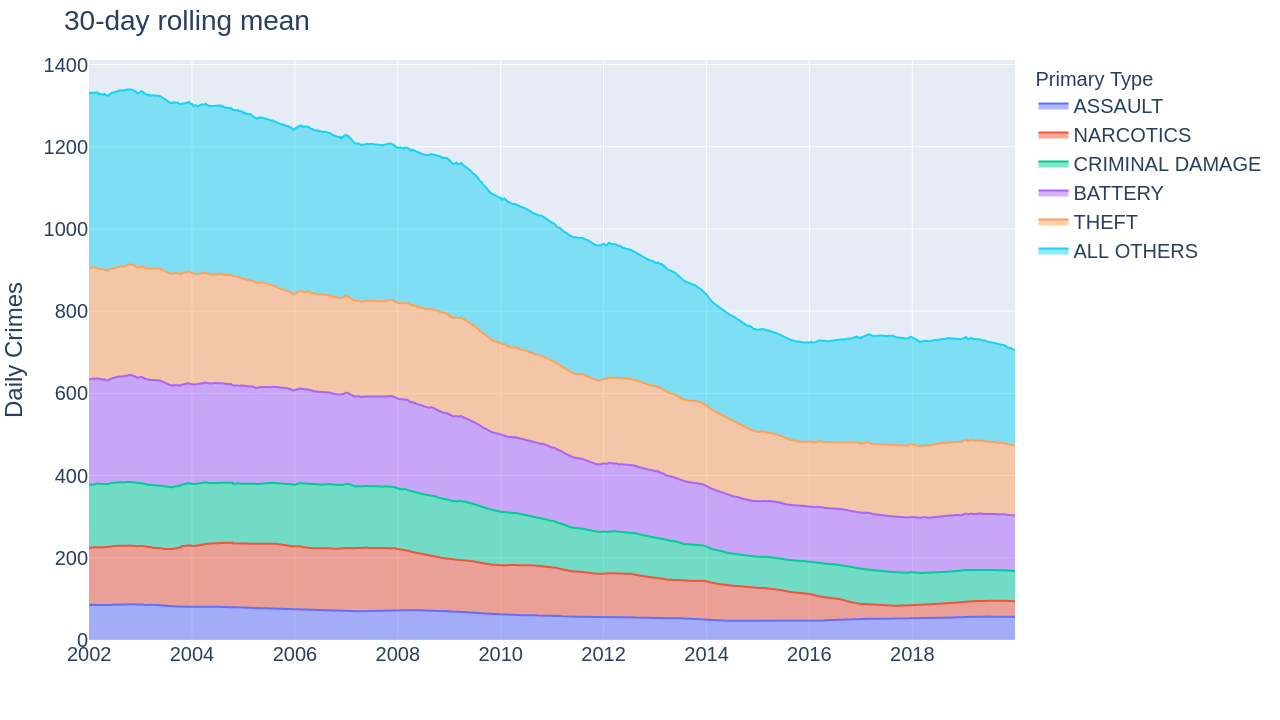

In [21]:
fig = px.area(agg_mean, color='Primary Type', 
              category_orders={'Primary Type':list(top_crimes[::-1])}, 
              labels={'value':'Daily Crimes', 'index':''})
fig.update_layout(font={'size':20}, title='30-day rolling mean')
fig.show('png', width=1280, height=720)  # png for static rendering

## Where do crimes occur?
<a id='location'></a>

Let's look at where crimes occur. If you would like to look at interactive versions of these plots, visit [my website](http://www.physics.rutgers.edu/~applebaum/visualizations/), where you can change the crime type and the time period of interest.

### [Choropleth](https://en.wikipedia.org/wiki/Choropleth_map) plotting function

This function plots the crime rate by neighborhood, and labels the highest and lowest crime rate neighborhoods. Similar plotting can be implemented more simply using plotly, as I did in this [interactive visualization](http://www.physics.rutgers.edu/~applebaum/visualizations/).

In [22]:
def plot_crime_map(df, geo_df, census_df, year, crime_type, cmap='Blues',
                   num_annotations=(3, 3), annot_colors=('black', 'black'), 
                   filename=None, **kwargs):
    """Plot the crime rate by neighborhood
    
    Args:
        df : the crime dataframe
        geo_df : the geopandas dataframe, for drawing the map
        census_df : the census dataframe
        year : either one year (year) 
            or a range of years, inclusively (min_year, max_year)
        crime_type : the type of crime to consider
        cmap (default 'Blues') : the colormap to use
        num_annotations (default (3, 3)) : if not zero, labels the
            highest and/or lowest crime rate neighborhoods. Should be
            2-tuple with (num_low, num_high), 
            the number of neighborhoods to label with 
            the lowest and highest crime rates, respectively
        annot_colors (default ('black', 'black')) : 2-tuple with colors 
            to use to plot low and high neighborhoods
        filename (default None) : save the figure to the path given by filename

        **kwargs
            vmax - maximum of colorbar
    """
    
    df = df.loc[df['Primary Type'] == crime_type.upper(), :].copy()
    geo_df = geo_df.copy()
    
    # determine behavior based on whether one year or a range
    try:
        _ = len(year)
        df = df.loc[(df['Year'] >= year[0]) & (df['Year'] <= year[1]), :]
        nyear = year[1] - year[0] + 1  # used to calculate rates per year
    except TypeError:
        df = df.loc[df['Year'] == year, :]
        nyear = 1  # used to calculate rates per year
    
    # adding crime rate to geopandas dataframe
    geo_df = geo_df.join(df['Community Area'].value_counts().rename('Rate'))
    # NaNs indicate no crimes occured, and were missing in the value counts
    geo_df = geo_df.replace(np.nan, 0)
    # convert to yearly number per 100,000 people
    geo_df['Rate'] = geo_df['Rate'] / census_df['Total Population'] / nyear * 1.e5

    # vmax sets the colorbar limit
    vmax = kwargs.get('vmax', geo_df['Rate'].max())
    ax = geo_df.plot(edgecolor='k', column='Rate', cmap=cmap, vmax=vmax,
                    figsize=(10, 8))
    
    fig = ax.get_figure()
    cax = fig.add_axes([0.88, 0.1, 0.025, 0.8])
    
    # explicitly create colormap as a workaround, since
    # the mappable is not returned by geopandas plot
    cmap1 = plt.cm.ScalarMappable(cmap=cmap)
    cmap1.set_clim(0, vmax)
    cbar = fig.colorbar(cmap1, cax=cax)
    
    if nyear > 1:
        year_label = f'{year[0]} to {year[1]}'
    else:
        year_label = f'{year}'
    cbar.set_label(f'{crime_type.title()} per 100k people per year, ' + year_label, 
                   rotation=270, fontsize=20, labelpad=20)
    
    ax.set_xlim([-88, -87.5])
    ax.set_ylim([41.6, 42.05])
    ax.set_xticks([])
    ax.set_yticks([])
    
    # Everything here deals with annotating the highest/lowest crime rate neighborhoods
    if np.sum(num_annotations) > 0:
        # first identify the neighborhoods to put in legend
        nlow, nhigh = num_annotations
        # assign empty series if no annotations are wanted
        # NB: lowest crime rate not necessarily unique if there are multiple zeros
        lowest_rate = geo_df['Rate'].sort_values().iloc[:nlow] if nlow > 0 else pd.Series([])
        highest_rate = geo_df['Rate'].sort_values().iloc[-nhigh:] if nhigh > 0 else pd.Series([])
        
        for i, (color, annot_group, leg_loc) in enumerate(zip(annot_colors, 
                                                              [lowest_rate, highest_rate],
                                                              ['center left', 'lower left'])):
            handles = []
            for num in annot_group.index:
                # labeling each area with its number
                # 2-digit numbers need to be bigger
                label = geo_df.loc[num, 'community'].title() + f', {geo_df.loc[num, "Rate"]:.1f}'
                pt = geo_df.loc[[num]].centroid.plot(ax=ax, marker=f'${num}$',
                                                     markersize=50 if num < 10 else 100,
                                                     color=color, label=label)
                # this version is just for the legend, with color='black' always
                handles.append(ax.scatter([], [], marker=f'${num}$,', 
                                          s=80 if num < 10 else 200,
                                          color='black', label=label))
            # creating the legend
            # the title is complicated as written, but is clear once rendered
            if len(annot_group) > 0:
                title = (r'$\bf{' + ('Lowest' if i == 0 else 'Highest') + '}$'
                         + r' $\bf{Crime\,Areas}$' + f'\nID #, Name, {crime_type.title()}/100k')
                leg = ax.legend(handles=handles, loc=leg_loc, 
                                title=title, fontsize=11, title_fontsize=11, handletextpad=0.5)
                leg._legend_box.align = "left"
                ax.add_artist(leg)
                
    if filename is not None:
        fig.savefig(filename, bbox_inches='tight')

### A few maps

Below we see the map of the homicide rate by neighborhood from 2015 to 2019. It looks like homicides are very inhomogenously distributed; a few neighborhoods on the South and West sides have the majority of homicides. Most Chicago neighborhoods have very low incidence of homicide.

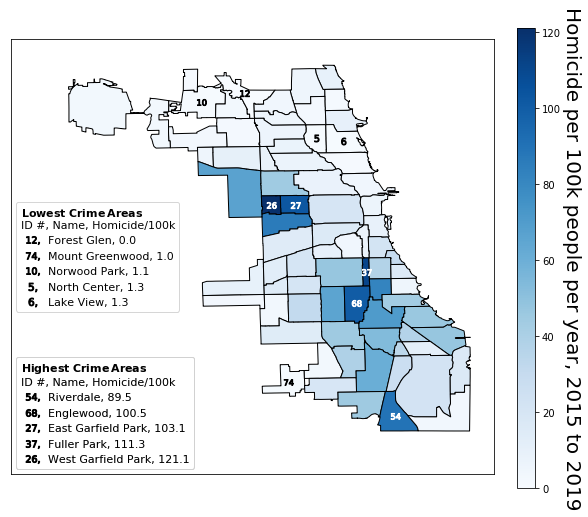

In [23]:
plot_crime_map(crimedata, geodf, census_dat, (2015, 2019), 'homicide', cmap='Blues', 
               num_annotations=(5, 5), annot_colors=('black', 'white'))

Thefts, on the other hand, are distributed very differently:

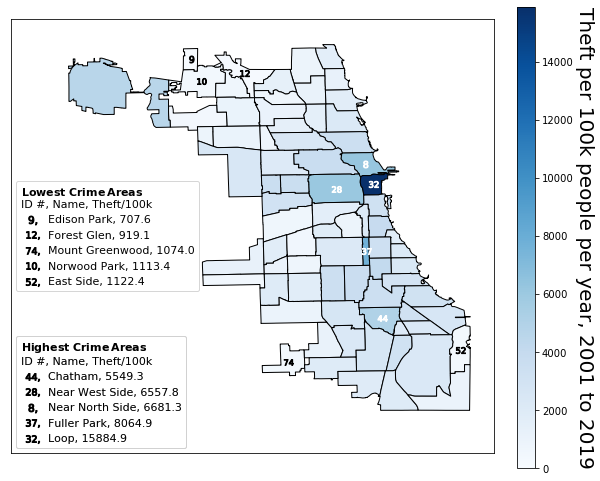

In [24]:
plot_crime_map(crimedata, geodf, census_dat, (2001, 2019), 'theft', cmap='Blues', 
               annotate=True, num_annotations=(5, 5), annot_colors=('black', 'white'))

By a huge margin, the highest rate of theft is in the Loop, which is Chicago's most important commercial center. We can see in the list of descriptions below that, unlike what we saw above, the most common thefts are From Building and Retail Theft. This makes sense, given the nature of the neighborhood. We can also probably safely assume that such a commercial area is not only subject to more thefts, but is also more diligent in reporting them. Finally, the rate (per 100k people) is based on census data, but a commercial area like the Loop likely has far more people working there than residing there, which would inflate the rate.

We can see that, in the Loop, the types of thefts are different from other thefts city-wide (see above). Thefts from building and retail theft are the most common in the Loop, whereas they are third and fourth most common city-wide.

In [25]:
crimedata.loc[(crimedata['Primary Type'] == 'THEFT') 
              & (crimedata['Community Area'] == 32), 'Description'].value_counts()

FROM BUILDING                       22903
RETAIL THEFT                        18993
$500 AND UNDER                      18589
OVER $500                           16148
POCKET-PICKING                       9040
FINANCIAL ID THEFT: OVER $300         869
PURSE-SNATCHING                       697
ATTEMPT THEFT                         646
FINANCIAL ID THEFT:$300 &UNDER        291
ATTEMPT FINANCIAL IDENTITY THEFT      104
FROM COIN-OP MACHINE/DEVICE            46
AGG: FINANCIAL ID THEFT                45
DELIVERY CONTAINER THEFT                7
OVER $300                               2
Name: Description, dtype: int64

## What is the periodicity of crime?
<a id='psd'></a>

In this section, we look in more detail at how crime varies on different timescales. We use the [power spectral density (PSD)](https://en.wikipedia.org/wiki/Spectral_density) of crimes in Chicago over the last 19 years (Technically, this is a modified [periodogram](https://en.wikipedia.org/wiki/Periodogram) constructed using [Welch's method](https://en.wikipedia.org/wiki/Welch%27s_method)).

### Helpful plotting funciton

This function does the plotting, with the option to also visualize the raw and detrended time series.

In [26]:
def crime_periodogram(crime_df, crime_type=None, ax=None, plot_trends=False):
    """Estimate the power spectral density of crime.
    
    Use Welch's method to estimate the PSD of crimes.
    
    crime_df : the crime dataframe
    crime_type (default None) : the type of crime to consider, or all crimes
    ax (default None) : if not None, the axis on which to plot
    plot_trends (default False) : if True, plot the data and detrended data
    """
    
    if crime_type is not None and str.lower(crime_type) != 'all':
        crime_df = crime_df.loc[crime_df['Primary Type'] == str.upper(crime_type), :]
        
    # resampling crimes into daily counts
    crimes_sampled_daily = (crime_df.index - crimedata.index.min()).days.value_counts().sort_index()
    
    # detrending the time series by subtracting a linear term
    X_to_fit = crimes_sampled_daily.index.values[np.newaxis, :].transpose()
    # we use simple linear regression to determine the trend line
    trend = LinearRegression().fit(X_to_fit,
                                   crimes_sampled_daily.values[np.newaxis, :].transpose())
    
    detrended_crimes = crimes_sampled_daily - trend.predict(X_to_fit).transpose()[0]

    # shows what the raw counts and detrended data look like
    if plot_trends:
        fig_trend, ax_trend = plt.subplots(2, 1, sharex=True)
        fig_trend.subplots_adjust(hspace=0)
        fig_trend.set_size_inches(5, 5)
        # plot the underlying crime rate time series
        ax_trend[0].plot(crimes_sampled_daily, label='Data')
        # plot the trend line
        ax_trend[0].plot(X_to_fit.transpose()[0], trend.predict(X_to_fit).transpose()[0], 
                label='Trend Fit', lw=3)
        ax_trend[0].legend(fontsize=14)
        ax_trend[1].axhline(0, color='black', ls='--')
        # plot the detrended time series
        ax_trend[1].plot(detrended_crimes, label='Detrended Data')
        ax_trend[1].set_ylabel('Residual', fontsize=14)
        ax_trend[1].set_xlabel('Days', fontsize=14)
        ax_trend[0].set_ylabel('Daily Crime Rate', fontsize=14)
        ax_trend[1].legend(fontsize=14)

    # scipy's implementation of Welch's method, using default window function
    freq, psd = ssi.welch(detrended_crimes, nperseg=1024)
    freq *= 365  # put frequency in 1/year, 1/day
    
    # identify where once per year frequencies occur
    yearly = np.argmin(abs(freq - 1))
    
    if ax is None:
        fig, ax = plt.subplots(1, 1)
        fig.set_size_inches(7, 5)
        ax.set_yscale('log')
        for loc in ['top', 'left', 'right']:
            ax.spines[loc].set_visible(False)
        ax.tick_params(axis='y', which='both', left=False, labelleft=False)
    ax.plot(freq, psd, lw=2)
    ax.annotate('Yearly', xy=(freq[yearly], psd[yearly]))
    ax.set_xlabel('Frequency [year$^{-1}$]', fontsize=14)
#     ax.set_ylabel('PSD', fontsize=14)

    # label other peaks in power spectral density without repeating yearly
    local_maxima = ssi.argrelextrema(psd, np.greater, order=100)
    global_maxima = np.argsort(psd)[-10:]
    # exclude lowest frequency, which is an artifact of insufficient detrending
    for ind in local_maxima[0][1:]:
        if ind in global_maxima and ind != yearly:
            ax.annotate(f'Every {365/freq[ind]:.1f} days', xy=(freq[ind], psd[ind]))

### A few plots

This plot shows the PSD for all crimes in the city. For reference, I also show the time series (both the raw counts and the de-trended data).

The peaks are places where there is more periodicity/variation in the signal. Almost every crime has its highest peak at the frequency coinciding with a once-per-year frequency. This is not surprising, given what we saw in the plots of crimes as a function of time --- they seem to increase in summer and decrease in winter in a periodic way. Things that have weekly periodicity could result from a routine weekend/weekday divide (another common peak is once every 3.5 days, which are the harmonics of the weekly variation).

Text(0.5, 1.0, 'Power Spectral Density of All Crimes')

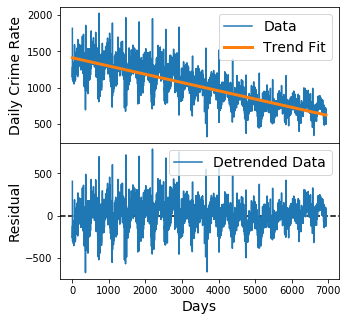

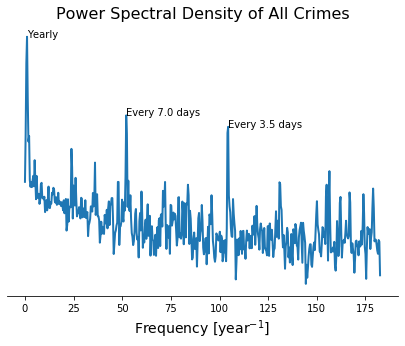

In [27]:
crime_periodogram(crimedata, crime_type='all', plot_trends=True)
plt.title('Power Spectral Density of All Crimes', fontsize=16)

Here's the PSD for burglary - we can see even stronger variation on the given timescales. This is not terribly surprising, since burglary involves entering a property to commit a crime. Whether people are home plays a big role in the timing of these crimes. As we can see in the plot after the PSD, burglaries are far less frequent on weekends (when people are home), which leads to this strong weekly trend.

Text(0.5, 1.0, 'Power Spectral Density of Burglaries')

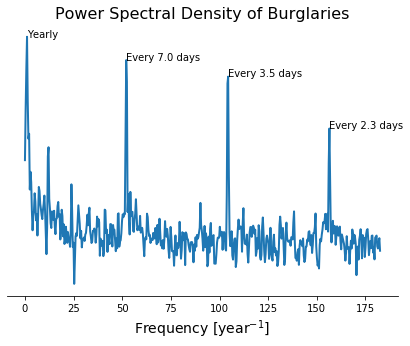

In [28]:
crime_periodogram(crimedata, crime_type='burglary')
plt.title('Power Spectral Density of Burglaries', fontsize=16)

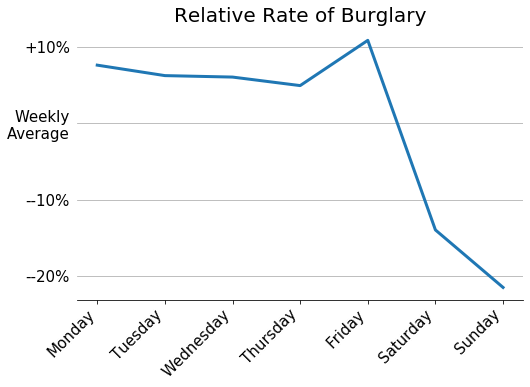

In [29]:
with plt.style.context('mplstyles/crimerate.mplstyle'):
    fig, ax = plt.subplots(1, 1)
    
    # aggregate counts, grouped by time of day and crime type
    burglary = crimedata.loc[crimedata['Primary Type'] == 'BURGLARY']
    agg = burglary.groupby(burglary.index.weekday).size()
    
    # set limits and labels
    generate_yaxis(ax, [-20, -10, 0, 10], center='Weekly\nAverage')
    ax.set_xticks(np.arange(7))
    ax.set_xticklabels([x + 'day' for x in ['Mon', 'Tues', 'Wednes', 
                                            'Thurs', 'Fri', 'Satur', 'Sun']], 
                       rotation=45, ha='right')
    ax.set_title('Relative Rate of Burglary')
    plot_rate_and_label(ax, agg.index, agg, '', 3, 10)
    
 